### Plan of attack

1. Read in netcdf file for monthly tmp mem001
2. Read in HadiSST data
3. Calculate Nino3.4 index
4. Calculate Monthly temperature anomalies
5. Caclculate regression

THEN

6. Read in first 8 ensemble members
7. Calculate regression
8. Calculate some measure of spread
9. Plot against GDP per capita
10. Repeat for precip 

In [6]:
import xarray as xr
import numpy as np
import dask.array as da
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [7]:
temp_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/temp/monthly_tmp_mem001_mem008.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110})
temp_data = temp_ds.TMP

In [8]:
# Detrend temp data
temp_data_dt = xr.apply_ufunc(func.detrend_2step, temp_data, 
                             input_core_dims=[['time']],
                             output_core_dims=[['time']],
                             vectorize=True,
                             dask='parallelized')

temp_data_dt = temp_data_dt.transpose(*temp_data.dims)

In [9]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [10]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [11]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1870-11', '2015-10'))/sst_std

In [12]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [13]:
def ensemble_regression(data, nino):

    # Calculate monthly temperature anomalies 
    climatology = data.sel(time=slice('1950','1979')).groupby('time.month').mean()
    anom = data.groupby('time.month')-climatology 
    
    # Smooth with 3-month running mean
    anom_rolling = anom.rolling(time=3).mean().sel(time=slice('1870-11', '2015-10'))
    
    # Take mean over every quarter 
    quarterly_anom = anom_rolling.resample(time='QS-NOV').mean('time')

    # Calculate instantaneous regression 
    quarterly_regression = func.regress_nino_by_month(quarterly_anom, nino)
    
    return quarterly_regression 

In [14]:
# Loop over ensemble members and calculate instantaneous regression 
regression_list = []
for m in temp_data_dt.member:
    regression_list.append(ensemble_regression(temp_data_dt.sel(member=m), nino_ndj))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 166 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 166 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 166 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 166 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-

In [15]:
regressions = xr.concat(regression_list, dim='member')

Text(0.5, 0, 'Degrees [C] per SD')

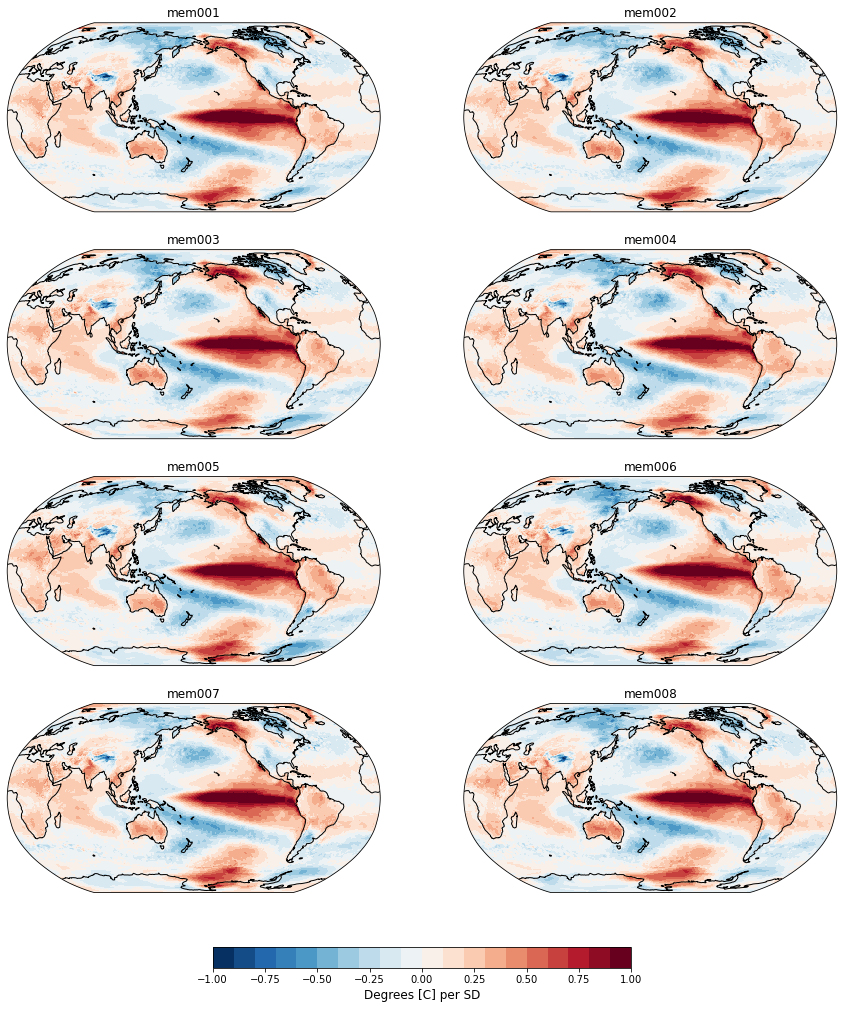

In [16]:
# Plot regression for each ensemble member 

fig = plt.figure(figsize=(15,20))
axs = []

columns = 2
rows = 4

vmin = -1
vmax = 1

for i, m in enumerate(regressions.member):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.Robinson(180))
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = regressions.sel(month=11).sel(member=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Colorbar
cbar = plt.colorbar(C, ax=axs, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('Degrees [C] per SD', fontsize=12)

In [17]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, regressions.sel(month=11))